In [1]:
#Importing various required libraries
import numpy as np
import pandas as pd
import json
import requests

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [3]:
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
import seaborn as sns

In [4]:
from geopy.geocoders import Nominatim

In [5]:
!pip install folium
import folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 5.0 MB/s  eta 0:00:01


In [6]:
from pandas import json_normalize #normalizing and flattens JSON data

In [7]:
#Getting data from the Wikipedia page and parsing data using BeautifulSoup (transforms the data in the Wiki page into a more readable format)
Data = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_V').text
Parse = BeautifulSoup(Data, 'html.parser')

In [8]:
#Creating necessary headers for a dataframe and retrieving information needed
PostalCode = []
Borough = []
Neighborhood = []

count = 0
for row in Parse.find('table').find_all('tr'):
    unit = row.find_all('td')
    #print(unit)
    for item in unit:
        PC = item.find_all('b')[0].text
        try:
            Bor = item.find_all('a')[0].text
        except:
            Bor = item.find_all('i')[0].text
        
        if 'Vancouver' in Bor:
            count = count + 1
            PostalCode.append(PC)
            Borough.append(Bor)
            if Bor != 'Not assigned':
                num = len(item.find_all('a'))
               
                Ngh = ''
                if (num>1): #has neighborhoods!
                    for i in range(1, num):
                        Neigh = item.find_all('a')[i].text
                        if i == num-1:
                            Ngh = Ngh + Neigh
                        else:
                            Ngh = Ngh + Neigh +','
                Neighborhood.append(Ngh)
                        
print(count)
          

44


In [9]:
# #Creating the dataframe with the necessary columns: PostalCode, Borough and Neighborhood
df_Vancouv = pd.DataFrame({"PostalCode": PostalCode,
                          "Borough":Borough,
                          "Neighborhood": Neighborhood})
df_Vancouv.head()


PostalCode    Borough                                       Neighborhood
0        V6A  Vancouver             Strathcona,Chinatown,Downtown Eastside
1        V6B  Vancouver  Downtown,Gastown,Harbour Centre,International ...
2        V6C  Vancouver               Waterfront,Coal Harbour,Canada Place
3        V6E  Vancouver                             West End,Davie Village
4        V6G  Vancouver                              West End,Stanley Park

In [10]:
!wget https://raw.githubusercontent.com/abhijithr94/Coursera_Capstone/main/Final%20Project%20-%20Vancouver%20Neighborhood/Data/VancouverCoordinates.csv
!ls
#acquiring the csv file

--2021-04-08 00:11:20--  https://raw.githubusercontent.com/abhijithr94/Coursera_Capstone/main/Final%20Project%20-%20Vancouver%20Neighborhood/Data/VancouverCoordinates.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1292 (1.3K) [text/plain]
Saving to: ‘VancouverCoordinates.csv’

VancouverCoordinate 100%[===================>]   1.26K  --.-KB/s    in 0s      

2021-04-08 00:11:20 (22.6 MB/s) - ‘VancouverCoordinates.csv’ saved [1292/1292]

VancouverCoordinates.csv


In [11]:
df_Vanc = pd.read_csv('VancouverCoordinates.csv') #Reading the downloaded csv file
df_Vanc.head()

PostalCode   Latitude   Longitude
0        V5K  49.275993 -123.015502
1        V5L  49.278096 -123.065637
2        V5M  49.259781 -123.042185
3        V5N  49.255868 -123.066669
4        V5P  49.223874 -123.067866

In [12]:
df_Vanc.shape

(44, 3)

In [13]:
df_Vancouver = pd.merge(df_Vancouv, df_Vanc, on = 'PostalCode')
df_Vancouver.head() #Merging the postal codes CSV file to the webscraping dataframe

PostalCode    Borough                                       Neighborhood  \
0        V6A  Vancouver             Strathcona,Chinatown,Downtown Eastside   
1        V6B  Vancouver  Downtown,Gastown,Harbour Centre,International ...   
2        V6C  Vancouver               Waterfront,Coal Harbour,Canada Place   
3        V6E  Vancouver                             West End,Davie Village   
4        V6G  Vancouver                              West End,Stanley Park   

    Latitude   Longitude  
0  49.278849 -123.091062  
1  49.278755 -123.112479  
2  49.285471 -123.116483  
3  49.283854 -123.127602  
4  49.288790 -123.135592

In [14]:
df_Vancouver.shape

(44, 5)

In [15]:
#Using geocoder and Nominatim to get the exact coordinates of Vancouver, BC
address = 'Vancouver, BC'
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='Vancouver_explorer')
location = geolocator.geocode(address)
latitude_V = location.latitude
longitude_V = location.longitude
print('The geographical coordinate of Vancouver are {}, {}'.format(latitude_V, longitude_V))

The geographical coordinate of Vancouver are 49.2608724, -123.1139529


In [16]:
#Creating a map of the neighborhood of Vancouver
map_Vancouver = folium.Map(location = [latitude_V, longitude_V], zoom_start =10)

for lat, lng, borough, neighborhood in zip(df_Vancouver['Latitude'],
                                          df_Vancouver['Longitude'],
                                          df_Vancouver['Borough'],
                                          df_Vancouver['Neighborhood']):
    label = '{},{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius =5,
    popup=label,
    color='cyan',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_Vancouver)
    
map_Vancouver 

In [17]:
#Using Foursquare API and Credentials to retrieve various venues
CLIENT_ID = 'VQSPI1IZ52EK30N3P41WN1ZKLKMXWWVAARP00PEFD1YV3TIC'
CLIENT_SECRET = 'LGSC53KN0SLJUFFCWLRS0MANOZ3PH2N1YZKG40E1W2FURE5X'
VERSION = '20201212'
#Use your credentials to test the code out

In [18]:
# To get nearby venues with a radius of 2000m and a limit of 500
LIMIT = 500
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        #create API request URL
        url ='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, 
                                                                                                                            CLIENT_SECRET,
                                                                                                                            VERSION,
                                                                                                                            lat,
                                                                                                                            lng,
                                                                                                                            radius,
                                                                                                                            LIMIT)
        #make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #return only relevant info for each nearby venue
        venues_list.append([(
            name,
        lat,
        lng,
        v['venue']['name'],
        v['venue']['location']['lat'],
        v['venue']['location']['lng'],
        v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                            'Neighborhood Latitude',
                            'Neighborhood Longitude',
                            'Venue',
                            'Venue Latitude',
                            'Venue Longitude',
                            'Venue Category']
    return(nearby_venues)

In [19]:
Vancouver_venues = getNearbyVenues(names=df_Vancouver['Neighborhood'],
                                latitudes=df_Vancouver['Latitude'],
                                longitudes=df_Vancouver['Longitude'])
Vancouver_venues.head() #displaying the top 5 venues

Strathcona,Chinatown,Downtown Eastside
Downtown,Gastown,Harbour Centre,International Village,Victory Square,Yaletown
Waterfront,Coal Harbour,Canada Place
West End,Davie Village
West End,Stanley Park

Fairview,Granville Island,Shaughnessy

Shaughnessy,Kitsilano,Quilchena

Hastings-Sunrise
Kitsilano,Greektown

Grandview-Woodland
Arbutus Ridge,Dunbar-Southlands

Hastings-Sunrise,Renfrew-Collingwood
Shaughnessy,Oakridge,Kerrisdale,Arbutus Ridge

Grandview-Woodland,Kensington-Cedar Cottage
Kerrisdale,Dunbar-Southlands,Musqueam

Kensington-Cedar Cottage,Victoria-Fraserview
Kerrisdale,Oakridge,Marpole

Renfrew-Collingwood
Kitsilano,West Point Grey,Jericho

Killarney
Dunbar-Southlands,Chaldecutt,University Endowment Lands

Mount Pleasant
UBC

Kensington-Cedar Cottage,Riley Park-Little Mountain

Riley Park-Little Mountain,Kensington-Cedar Cottage,Oakridge,Sunset

Oakridge,Marpole,Sunset
Bentall Centre
Mount Pleasant,Riley Park-Little Mountain
Pacific Centre
Fairview,South Cambie
Downtown


Neighborhood  Neighborhood Latitude  \
0  Strathcona,Chinatown,Downtown Eastside              49.278849   
1  Strathcona,Chinatown,Downtown Eastside              49.278849   
2  Strathcona,Chinatown,Downtown Eastside              49.278849   
3  Strathcona,Chinatown,Downtown Eastside              49.278849   
4  Strathcona,Chinatown,Downtown Eastside              49.278849   

   Neighborhood Longitude                       Venue  Venue Latitude  \
0             -123.091062                Union Market       49.277371   
1             -123.091062                  Phnom Penh       49.278517   
2             -123.091062          The Mackenzie Room       49.283168   
3             -123.091062  Matchstick Coffee Roasters       49.278626   
4             -123.091062                      Boxcar       49.276613   

   Venue Longitude    Venue Category  
0      -123.086989     Deli / Bodega  
1      -123.098214  Asian Restaurant  
2      -123.094911        Restaurant  
3      -123.099303              Café  
4      -123.100076               Bar

In [20]:
Vancouver_venues.groupby('Neighborhood').count() #grouping the venues by the neighborhood

Neighborhood Latitude  \
Neighborhood                                                                
                                                                      734   
Arbutus Ridge,Dunbar-Southlands                                       100   
Bentall Centre                                                        100   
Downtown                                                              100   
Downtown,Gastown,Harbour Centre,International V...                    100   
Dunbar-Southlands,Chaldecutt,University Endowme...                     95   
Fairview,Granville Island,Shaughnessy                                 100   
Fairview,South Cambie                                                 100   
Grandview-Woodland                                                    100   
Grandview-Woodland,Kensington-Cedar Cottage                           100   
Hastings-Sunrise                                                      100   
Hastings-Sunrise,Renfrew-Collingwood                                   74   
Kensington-Cedar Cottage,Riley Park-Little Moun...                    100   
Kensington-Cedar Cottage,Victoria-Fraserview                          100   
Kerrisdale,Dunbar-Southlands,Musqueam                                  74   
Kerrisdale,Oakridge,Marpole                                            81   
Killarney                                                              80   
Kitsilano,Greektown                                                   100   
Kitsilano,West Point Grey,Jericho                                     100   
Mount Pleasant                                                        100   
Mount Pleasant,Riley Park-Little Mountain                             100   
Oakridge,Marpole,Sunset                                                99   
Pacific Centre                                                        100   
Renfrew-Collingwood                                                   100   
Riley Park-Little Mountain,Kensington-Cedar Cot...                    100   
Shaughnessy,Kitsilano,Quilchena                                       100   
Shaughnessy,Oakridge,Kerrisdale,Arbutus Ridge                          73   
Strathcona,Chinatown,Downtown Eastside                                100   
UBC                                                                    68   
Waterfront,Coal Harbour,Canada Place                                  100   
West End,Davie Village                                                100   
West End,Stanley Park                                                 100   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
                                                                       734   
Arbutus Ridge,Dunbar-Southlands                                        100   
Bentall Centre                                                         100   
Downtown                                                               100   
Downtown,Gastown,Harbour Centre,International V...                     100   
Dunbar-Southlands,Chaldecutt,University Endowme...                      95   
Fairview,Granville Island,Shaughnessy                                  100   
Fairview,South Cambie                                                  100   
Grandview-Woodland                                                     100   
Grandview-Woodland,Kensington-Cedar Cottage                            100   
Hastings-Sunrise                                                       100   
Hastings-Sunrise,Renfrew-Collingwood                                    74   
Kensington-Cedar Cottage,Riley Park-Little Moun...                     100   
Kensington-Cedar Cottage,Victoria-Fraserview                           100   
Kerrisdale,Dunbar-Southlands,Musqueam                                   74   
Kerrisdale,Oakridge,Marpole                                             81   
Killarney                    

In [21]:
#Number of unique categories
print('There are {} uniques categories.'.format(len(Vancouver_venues['Venue Category'].unique())))
print("The Venue Categories are", Vancouver_venues['Venue Category'].unique())

There are 248 uniques categories.
The Venue Categories are ['Deli / Bodega' 'Asian Restaurant' 'Restaurant' 'Café' 'Bar'
 'Pizza Place' 'Chinese Restaurant' 'Cocktail Bar' 'Italian Restaurant'
 'Boxing Gym' 'Brewery' 'Coffee Shop' 'Park' 'Ice Cream Shop' 'Beer Bar'
 'Sushi Restaurant' 'Music Store' 'Vegetarian / Vegan Restaurant' 'Trail'
 'Tech Startup' 'Dessert Shop' 'Gourmet Shop' 'Gym' 'Auto Dealership'
 'Science Museum' 'Hockey Arena' 'Bakery' 'Lounge' 'Liquor Store'
 'Belgian Restaurant' 'Sandwich Place' 'American Restaurant'
 'Breakfast Spot' 'Community Center' 'Clothing Store'
 'Fried Chicken Joint' 'Theater' 'Taco Place' 'Gastropub' 'Nightclub'
 'Tapas Restaurant' 'Stadium' 'Furniture / Home Store' 'Juice Bar'
 'Seafood Restaurant' 'Japanese Restaurant' 'Outdoor Supply Store'
 'Outdoor Sculpture' 'Hotel' 'Dog Run' 'Steakhouse' 'Donut Shop'
 'Thai Restaurant' 'Indian Restaurant' 'Cuban Restaurant' 'Concert Hall'
 'Toy / Game Store' 'Cosmetics Shop' 'Noodle House' 'Hot Dog Joint'

In [22]:
#Converting data into a numerical form for easier Machine learning purposes
#Using One hot encoding for the above purpose
V_onehot = pd.get_dummies(Vancouver_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
V_onehot['Neighborhood'] = Vancouver_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [V_onehot.columns[-1]] + list(V_onehot.columns[:-1])
V_onehot = V_onehot[fixed_columns]
print(V_onehot.shape)
V_onehot.head()

(3678, 248)


Yoga Studio  Accessories Store  American Restaurant  Amphitheater  \
0            0                  0                    0             0   
1            0                  0                    0             0   
2            0                  0                    0             0   
3            0                  0                    0             0   
4            0                  0                    0             0   

   Aquarium  Arcade  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0         0       0            0                    0                 0   
1         0       0            0                    0                 1   
2         0       0            0                    0                 0   
3         0       0            0                    0                 0   
4         0       0            0                    0                 0   

   Athletics & Sports  ...  Vegetarian / Vegan Restaurant  Video Game Store  \
0                   0  ...                              0                 0   
1                   0  ...                              0                 0   
2                   0  ...                              0                 0   
3                   0  ...                              0                 0   
4                   0  ...                              0                 0   

   Video Store  Vietnamese Restaurant  Volleyball Court  Waterfall  \
0            0                      0                 0          0   
1            0                      0                 0          0   
2            0                      0                 0          0   
3            0                      0                 0          0   
4            0                      0                 0          0   

   Waterfront  Wine Bar  Wine Shop  Women's Store  
0           0         0          0              0  
1           0         0          0              0  
2           0         0          0              0  
3           0         0          0              0  
4           0         0          0              0  

[5 rows x 248 columns]

In [23]:
V_grouped = V_onehot.groupby(["Neighborhood"]).mean().reset_index() #Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
V_grouped = V_grouped.iloc[1:] #Ignoring the first row as its giving an off value with no neighborhood
V_grouped.shape
V_grouped.head()

Neighborhood  Yoga Studio  \
1                    Arbutus Ridge,Dunbar-Southlands     0.010000   
2                                     Bentall Centre     0.010000   
3                                           Downtown     0.010000   
4  Downtown,Gastown,Harbour Centre,International ...     0.000000   
5  Dunbar-Southlands,Chaldecutt,University Endowm...     0.010526   

   Accessories Store  American Restaurant  Amphitheater  Aquarium  Arcade  \
1                0.0                 0.00           0.0       0.0     0.0   
2                0.0                 0.01           0.0       0.0     0.0   
3                0.0                 0.00           0.0       0.0     0.0   
4                0.0                 0.01           0.0       0.0     0.0   
5                0.0                 0.00           0.0       0.0     0.0   

   Art Gallery  Arts & Crafts Store  Asian Restaurant  ...  \
1         0.00             0.000000          0.010000  ...   
2         0.00             0.010000          0.000000  ...   
3         0.01             0.000000          0.000000  ...   
4         0.01             0.000000          0.020000  ...   
5         0.00             0.010526          0.010526  ...   

   Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
1                       0.010000               0.0          0.0   
2                       0.000000               0.0          0.0   
3                       0.000000               0.0          0.0   
4                       0.010000               0.0          0.0   
5                       0.031579               0.0          0.0   

   Vietnamese Restaurant  Volleyball Court  Waterfall  Waterfront  Wine Bar  \
1                   0.01               0.0        0.0        0.00      0.00   
2                   0.01               0.0        0.0        0.02      0.01   
3                   0.01               0.0        0.0        0.02      0.01   
4                   0.01               0.0        0.0        0.01      0.00   
5                   0.00               0.0        0.0        0.00      0.00   

   Wine Shop  Women's Store  
1       0.00            0.0  
2       0.00            0.0  
3       0.01            0.0  
4       0.00            0.0  
5       0.00            0.0  

[5 rows x 248 columns]

In [24]:
Indian_res = V_grouped[['Neighborhood',"Indian Restaurant"]] #Creating a dataframe with the grouped one hot encoding dataframe and limiting it to only Indian restaurants
Indian_res.head()

Neighborhood  Indian Restaurant
1                    Arbutus Ridge,Dunbar-Southlands           0.010000
2                                     Bentall Centre           0.030000
3                                           Downtown           0.010000
4  Downtown,Gastown,Harbour Centre,International ...           0.000000
5  Dunbar-Southlands,Chaldecutt,University Endowm...           0.010526

<Figure size 1440x216 with 0 Axes>

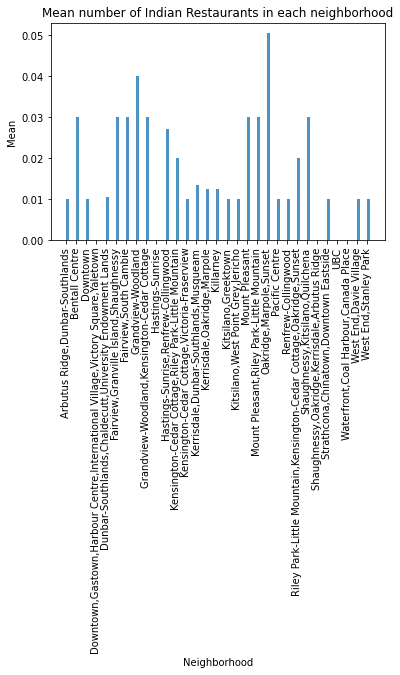

<Figure size 1440x216 with 0 Axes>

In [25]:
#Plotting a graph of the mean of frequency of Indian restaurants for each neighborhood
plt.bar(Indian_res['Neighborhood'],Indian_res['Indian Restaurant'], width = 0.3, align='edge',alpha=0.8)
plt.xticks(rotation=90)
plt.xlabel('Neighborhood')
plt.ylabel('Mean')
plt.title('Mean number of Indian Restaurants in each neighborhood')
plt.figure(figsize=(20, 3))

In [26]:
!pip install kneed

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [27]:
#importing some libraries to help detemine the optimal number of clusters
from sklearn.cluster import KMeans
from kneed import KneeLocator

In [28]:
Vancouver_g = Indian_res.drop('Neighborhood', 1)

In [29]:
#Using the elbow method to evaluate the appropriate number of clusters
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(Vancouver_g)
    sse.append(kmeans.inertia_)

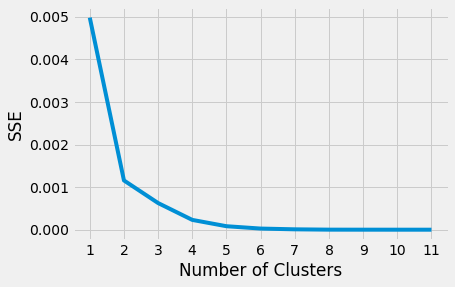

In [30]:
#Plotting the number of clusters againt the sum of squares error 
plt.style.use("fivethirtyeight")
plt.plot(range(1, 12), sse)
plt.xticks(range(1, 12))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [31]:
#From kneed using kneelocator to confirm optimal number of clusters
kl = KneeLocator(
    range(1, 12), sse, curve="convex", direction="decreasing"
)
print('Optimal number of clusters:',kl.elbow)

Optimal number of clusters: 3


In [32]:
K_M = KMeans(n_clusters = 3, random_state=0)
K_M.fit(Vancouver_g)
K_M.labels_[0:10]

array([0, 1, 0, 2, 0, 1, 1, 1, 1, 2], dtype=int32)

In [33]:
#Adding in cluster label for the Indian restaurant dataframe
V_merged = Indian_res.copy()
V_merged["Cluster Labels"] = K_M.labels_
V_merged.head()

Neighborhood  Indian Restaurant  \
1                    Arbutus Ridge,Dunbar-Southlands           0.010000   
2                                     Bentall Centre           0.030000   
3                                           Downtown           0.010000   
4  Downtown,Gastown,Harbour Centre,International ...           0.000000   
5  Dunbar-Southlands,Chaldecutt,University Endowm...           0.010526   

   Cluster Labels  
1               0  
2               1  
3               0  
4               2  
5               0

In [34]:
#Combining the above to the entire merged dataframe from before that shows all venues
V_merged = V_merged.join(Vancouver_venues.set_index('Neighborhood'), on = 'Neighborhood')

V_merged.sort_values(['Cluster Labels'], inplace = True)
V_merged

Neighborhood  Indian Restaurant  \
1                 Arbutus Ridge,Dunbar-Southlands               0.01   
17                            Kitsilano,Greektown               0.01   
17                            Kitsilano,Greektown               0.01   
17                            Kitsilano,Greektown               0.01   
17                            Kitsilano,Greektown               0.01   
..                                            ...                ...   
26  Shaughnessy,Oakridge,Kerrisdale,Arbutus Ridge               0.00   
26  Shaughnessy,Oakridge,Kerrisdale,Arbutus Ridge               0.00   
26  Shaughnessy,Oakridge,Kerrisdale,Arbutus Ridge               0.00   
28                                            UBC               0.00   
10                               Hastings-Sunrise               0.00   

    Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
1                0              49.250273             -123.162525   
17               0              49.265073             -123.162119   
17               0              49.265073             -123.162119   
17               0              49.265073             -123.162119   
17               0              49.265073             -123.162119   
..             ...                    ...                     ...   
26               2              49.234516             -123.146084   
26               2              49.234516             -123.146084   
26               2              49.234516             -123.146084   
28               2              49.267870             -123.239475   
10               2              49.275993             -123.015502   

                                     Venue  Venue Latitude  Venue Longitude  \
1                           The Patty Shop       49.250680      -123.167916   
17                   Parthenon Supermarket       49.264184      -123.173762   
17                                   Fable       49.267955      -123.149005   
17          Kitsilano Community Centre Gym       49.261736      -123.161936   
17                   Kitsilano Public Pool       49.273215      -123.157413   
..                                     ...             ...              ...   
26                     Kerrisdale Pharmacy       49.235578      -123.155881   
26                                 Phò Hōa       49.227038      -123.128739   
26            Cowboys and Angels Toy Store       49.234671      -123.156604   
28                      Shoppers Drug Mart       49.253155      -123.237098   
10  Brentwood Town Centre SkyTrain Station       49.266417      -123.001942   

           Venue Category  
1    Caribbean Restaurant  
17       Greek Restaurant  
17             Restaurant  
17   Gym / Fitness Center  
17                   Pool  
..                    ...  
26               Pharmacy  
26  Vietnamese Restaurant  
26       Toy / Game Store  
28               Pharmacy  
10     Light Rail Station  

[2944 rows x 9 columns]

In [35]:
#Using k-means clustering, creating a map for the 3 clusters
kclusters = 3

# create map
map_clusters = folium.Map(location=[latitude_V, longitude_V], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(V_merged['Neighborhood Latitude'], V_merged['Neighborhood Longitude'], V_merged['Neighborhood'], V_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [36]:
df = df_Vancouv[['Borough','Neighborhood']]
df.head() #A new dataframe that only shows the Borough and the neighborhood which will be used later

Borough                                       Neighborhood
0  Vancouver             Strathcona,Chinatown,Downtown Eastside
1  Vancouver  Downtown,Gastown,Harbour Centre,International ...
2  Vancouver               Waterfront,Coal Harbour,Canada Place
3  Vancouver                             West End,Davie Village
4  Vancouver                              West End,Stanley Park

In [37]:
Indian_res['Cluster Labels'] = K_M.labels_
Indian_res.head() #Displaying the Indian restaurants accordingly to their cluster labels and their associated neighborhood

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Neighborhood  Indian Restaurant  \
1                    Arbutus Ridge,Dunbar-Southlands           0.010000   
2                                     Bentall Centre           0.030000   
3                                           Downtown           0.010000   
4  Downtown,Gastown,Harbour Centre,International ...           0.000000   
5  Dunbar-Southlands,Chaldecutt,University Endowm...           0.010526   

   Cluster Labels  
1               0  
2               1  
3               0  
4               2  
5               0

In [38]:
Indian_res['Cluster Labels'].value_counts() #number of neighborhoods in each cluster label

0    16
1    10
2     5
Name: Cluster Labels, dtype: int64

In [39]:
FC = V_merged.loc[V_merged['Cluster Labels']==0] #creating a dataframe with the clusters in red color in the Folium map
df_FC=pd.merge(df,FC,on='Neighborhood')
df_FC 

Borough                            Neighborhood  Indian Restaurant  \
0     Vancouver  Strathcona,Chinatown,Downtown Eastside               0.01   
1     Vancouver  Strathcona,Chinatown,Downtown Eastside               0.01   
2     Vancouver  Strathcona,Chinatown,Downtown Eastside               0.01   
3     Vancouver  Strathcona,Chinatown,Downtown Eastside               0.01   
4     Vancouver  Strathcona,Chinatown,Downtown Eastside               0.01   
...         ...                                     ...                ...   
1525  Vancouver                                Downtown               0.01   
1526  Vancouver                                Downtown               0.01   
1527  Vancouver                                Downtown               0.01   
1528  Vancouver                                Downtown               0.01   
1529  Vancouver                                Downtown               0.01   

      Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0                  0              49.278849             -123.091062   
1                  0              49.278849             -123.091062   
2                  0              49.278849             -123.091062   
3                  0              49.278849             -123.091062   
4                  0              49.278849             -123.091062   
...              ...                    ...                     ...   
1525               0              49.277088             -123.125389   
1526               0              49.277088             -123.125389   
1527               0              49.277088             -123.125389   
1528               0              49.277088             -123.125389   
1529               0              49.277088             -123.125389   

                                             Venue  Venue Latitude  \
0                       East Vancouver Brewing Co.       49.276862   
1                               Black Rice Izakaya       49.278541   
2                                   Elysian Coffee       49.264621   
3                                      L'Hermitage       49.280139   
4                                      Medina Café       49.280565   
...                                            ...             ...   
1525                                     Nuba Café       49.275925   
1526                      The Cross Decor & Design       49.275160   
1527  Residence Inn by Marriott Vancouver Downtown       49.277905   
1528                       Nero Belgian Waffle Bar       49.278451   
1529                              Body Energy Club       49.277682   

      Venue Longitude             Venue Category  
0         -123.071112                    Brewery  
1         -123.114488                 Restaurant  
2         -123.104963                Coffee Shop  
3         -123.117480                      Hotel  
4         -123.116859             Breakfast Spot  
...               ...                        ...  
1525      -123.124440  Middle Eastern Restaurant  
1526      -123.123010     Furniture / Home Store  
1527      -123.128624                      Hotel  
1528      -123.122024               Dessert Shop  
1529      -123.126894       Gym / Fitness Center  

[1530 rows x 10 columns]

In [40]:
print('There are {} unique venue categories.'.format(len(df_FC['Venue Category'].unique())))

There are 180 unique venue categories.


In [41]:
SC = V_merged.loc[V_merged['Cluster Labels']==1] #creating a dataframe with the clusters in purple color in the Folium map
df_SC=pd.merge(df,SC,on='Neighborhood')
df_SC

Borough                           Neighborhood  Indian Restaurant  \
0    Vancouver  Fairview,Granville Island,Shaughnessy               0.03   
1    Vancouver  Fairview,Granville Island,Shaughnessy               0.03   
2    Vancouver  Fairview,Granville Island,Shaughnessy               0.03   
3    Vancouver  Fairview,Granville Island,Shaughnessy               0.03   
4    Vancouver  Fairview,Granville Island,Shaughnessy               0.03   
..         ...                                    ...                ...   
968  Vancouver                  Fairview,South Cambie               0.03   
969  Vancouver                  Fairview,South Cambie               0.03   
970  Vancouver                  Fairview,South Cambie               0.03   
971  Vancouver                  Fairview,South Cambie               0.03   
972  Vancouver                  Fairview,South Cambie               0.03   

     Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0                 1              49.256903             -123.130947   
1                 1              49.256903             -123.130947   
2                 1              49.256903             -123.130947   
3                 1              49.256903             -123.130947   
4                 1              49.256903             -123.130947   
..              ...                    ...                     ...   
968               1              49.251654             -123.119451   
969               1              49.251654             -123.119451   
970               1              49.251654             -123.119451   
971               1              49.251654             -123.119451   
972               1              49.251654             -123.119451   

                     Venue  Venue Latitude  Venue Longitude  \
0                    Vij's       49.257525      -123.115083   
1          Beaucoup Bakery       49.266403      -123.140748   
2            Rain Or Shine       49.255133      -123.115081   
3    Dragon Ball Tea House       49.249126      -123.127718   
4                    Suika       49.263540      -123.141651   
..                     ...             ...              ...   
968        Solly’s Bagelry       49.264784      -123.112698   
969          Anthropologie       49.259467      -123.138634   
970      Emelle's Catering       49.264601      -123.108680   
971   Jonathon Rogers Park       49.264080      -123.108029   
972          Chutney Villa       49.263044      -123.101841   

          Venue Category  
0      Indian Restaurant  
1                 Bakery  
2         Ice Cream Shop  
3        Bubble Tea Shop  
4    Japanese Restaurant  
..                   ...  
968           Bagel Shop  
969        Women's Store  
970               Bistro  
971                 Park  
972    Indian Restaurant  

[973 rows x 10 columns]

In [42]:
print('There are {} unique venue categories.'.format(len(df_SC['Venue Category'].unique())))

There are 152 unique venue categories.


In [43]:
TC = V_merged.loc[V_merged['Cluster Labels']==2] #creating a dataframe with the clusters in cyan color in the Folium map
df_TC=pd.merge(df,TC,on='Neighborhood')
df_TC

Borough                                       Neighborhood  \
0    Vancouver  Downtown,Gastown,Harbour Centre,International ...   
1    Vancouver  Downtown,Gastown,Harbour Centre,International ...   
2    Vancouver  Downtown,Gastown,Harbour Centre,International ...   
3    Vancouver  Downtown,Gastown,Harbour Centre,International ...   
4    Vancouver  Downtown,Gastown,Harbour Centre,International ...   
..         ...                                                ...   
436  Vancouver                                                UBC   
437  Vancouver                                                UBC   
438  Vancouver                                                UBC   
439  Vancouver                                                UBC   
440  Vancouver                                                UBC   

     Indian Restaurant  Cluster Labels  Neighborhood Latitude  \
0                  0.0               2              49.278755   
1                  0.0               2              49.278755   
2                  0.0               2              49.278755   
3                  0.0               2              49.278755   
4                  0.0               2              49.278755   
..                 ...             ...                    ...   
436                0.0               2              49.267870   
437                0.0               2              49.267870   
438                0.0               2              49.267870   
439                0.0               2              49.267870   
440                0.0               2              49.267870   

     Neighborhood Longitude                                Venue  \
0               -123.112479  The Keg Steakhouse + Bar - Yaletown   
1               -123.112479                      Seaside Seawall   
2               -123.112479                           PRADO Cafe   
3               -123.112479              The Flying Pig Yaletown   
4               -123.112479                         Invoke Media   
..                      ...                                  ...   
436             -123.239475                             Pita Pit   
437             -123.239475                            Biercraft   
438             -123.239475                            Seedlings   
439             -123.239475                   UBC Aquatic Centre   
440             -123.239475                   Shoppers Drug Mart   

     Venue Latitude  Venue Longitude                 Venue Category  
0         49.276623      -123.119442                     Restaurant  
1         49.272541      -123.104061                          Trail  
2         49.281908      -123.107295                    Coffee Shop  
3         49.275268      -123.122220                     Restaurant  
4         49.283547      -123.104078                   Tech Startup  
..              ...              ...                            ...  
436       49.266124      -123.242133                 Sandwich Place  
437       49.254245      -123.235422                     Restaurant  
438       49.268466      -123.257899  Vegetarian / Vegan Restaurant  
439       49.266824      -123.249264                       Gym Pool  
440       49.253155      -123.237098                       Pharmacy  

[441 rows x 10 columns]

In [44]:
print('There are {} unique venue categories.'.format(len(df_TC['Venue Category'].unique())))

There are 127 unique venue categories.


In [45]:
#list of indian restaurants in the first cluster
df_0 = df_FC.loc[df_FC['Venue Category'] == 'Indian Restaurant']
df_0.head()

Borough                            Neighborhood  Indian Restaurant  \
10   Vancouver  Strathcona,Chinatown,Downtown Eastside               0.01   
165  Vancouver                  West End,Davie Village               0.01   
239  Vancouver                   West End,Stanley Park               0.01   
328  Vancouver                     Kitsilano,Greektown               0.01   
410  Vancouver         Arbutus Ridge,Dunbar-Southlands               0.01   

     Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
10                0              49.278849             -123.091062   
165               0              49.283854             -123.127602   
239               0              49.288790             -123.135592   
328               0              49.265073             -123.162119   
410               0              49.250273             -123.162525   

                      Venue  Venue Latitude  Venue Longitude  \
10          Tandoori Palace       49.271653      -123.069721   
165             Crave India       49.279056      -123.123368   
239            Mumbai Local       49.280910      -123.132244   
328         The Indian Oven       49.268021      -123.150553   
410  Handi Cuisine of India       49.246758      -123.185250   

        Venue Category  
10   Indian Restaurant  
165  Indian Restaurant  
239  Indian Restaurant  
328  Indian Restaurant  
410  Indian Restaurant

In [46]:
df_0.shape

(18, 10)

In [47]:
#list of indian restaurants in the second cluster
df_1 = df_SC.loc[df_SC['Venue Category'] == 'Indian Restaurant']
df_1.head()

Borough                           Neighborhood  Indian Restaurant  \
0    Vancouver  Fairview,Granville Island,Shaughnessy               0.03   
35   Vancouver  Fairview,Granville Island,Shaughnessy               0.03   
68   Vancouver  Fairview,Granville Island,Shaughnessy               0.03   
148  Vancouver        Shaughnessy,Kitsilano,Quilchena               0.03   
167  Vancouver        Shaughnessy,Kitsilano,Quilchena               0.03   

     Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0                 1              49.256903             -123.130947   
35                1              49.256903             -123.130947   
68                1              49.256903             -123.130947   
148               1              49.259470             -123.141797   
167               1              49.259470             -123.141797   

                   Venue  Venue Latitude  Venue Longitude     Venue Category  
0                  Vij's       49.257525      -123.115083  Indian Restaurant  
35       The Indian Oven       49.268021      -123.150553  Indian Restaurant  
68   Indian Roti Kitchen       49.258950      -123.115087  Indian Restaurant  
148      The Indian Oven       49.268021      -123.150553  Indian Restaurant  
167                Vij's       49.257525      -123.115083  Indian Restaurant

In [48]:
df_1.shape

(32, 10)

In [49]:
#list of indian restaurants in the third cluster
df_2 = df_TC.loc[df_TC['Venue Category'] == 'Indian Restaurant']
df_2.head()

Empty DataFrame
Columns: [Borough, Neighborhood, Indian Restaurant, Cluster Labels, Neighborhood Latitude, Neighborhood Longitude, Venue, Venue Latitude, Venue Longitude, Venue Category]
Index: []

In [50]:
df_2.shape

(0, 10)

In [51]:
print('There are {} Indian restaurants.'.format(len(df_0['Venue'].unique())))

There are 12 Indian restaurants.


In [52]:
print('There are {} Indian restaurants.'.format(len(df_1['Venue'].unique())))

There are 16 Indian restaurants.


In [53]:
print('There are {} Indian restaurants.'.format(len(df_2['Venue'].unique())))

There are 0 Indian restaurants.


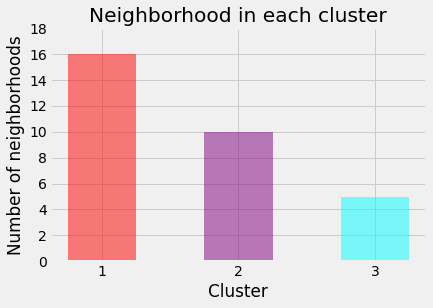

In [54]:
#Creating a map of number of neighborhoods in each cluster to compare with a mean frequency of Indian restaurants graph
item = (1,2,3)
Y = np.arange(len(item))
Val = Indian_res['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
V = Val['Cluster Labels'].tolist()
plt.bar(Y,V, width = 0.5, align='center',alpha=0.5,color = ['red','purple','cyan'])
plt.title('Neighborhood in each cluster')
plt.xticks(Y, item)
plt.yticks(np.arange(0, 20, step=2))
plt.xlabel('Cluster')
plt.ylabel('Number of neighborhoods')
plt.show()

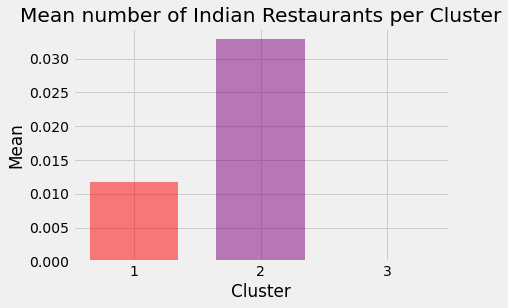

[0.011764705882352941, 0.0328879753340185, 0.0]

In [55]:
#Mean frequency graph of Indian restaurants in each cluster
mean_df=[df_FC['Indian Restaurant'].mean(),df_SC['Indian Restaurant'].mean(),df_TC['Indian Restaurant'].mean()]
item = (1,2,3)
Y = np.arange(len(item))
plt.bar(Y,mean_df, width = 0.7, align='center',alpha=0.5,color = ['red','purple','cyan'])
plt.title('Mean number of Indian Restaurants per Cluster')
plt.xticks(Y, item)
plt.xlabel('Cluster')
plt.ylabel('Mean')
plt.show()
mean_df

## Conclusion
###  - Cluster1 has 16 neighborhoods, Cluster2 has 10 neighborhoods and finally Cluster3 has 5 neighborhoods
###  - Cluster2 which occupies 10 different neighborhoods and has 16 Indian restaurants. Comparatively a popular place for Indian food in the neighborhoods in this cluster
###  - Cluster3 which occupies 5 different neighborhoods and has no Indian restaurants would be an ideal spot to start up an Indian restaurant!
###  - Cluster1 which occupies 16 different neighborhoods and currently has 12 Indian restaurants would be the next optimal spot to open up a restaurant!

